In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = [15, 10]

## 1. Linear Regression on Time Series Data

In [3]:
df = pd.read_csv('time_series.csv')
df['date'] = pd.to_datetime(df['date'])

In [4]:
## to check basic info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    17420 non-null  datetime64[ns]
 1   X1      17420 non-null  float64       
 2   X2      17420 non-null  float64       
 3   X3      17420 non-null  float64       
 4   X4      17420 non-null  float64       
 5   X5      17420 non-null  float64       
 6   X6      17420 non-null  float64       
 7   Y       17420 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.1 MB


All the columns have values and none is empty

In [4]:
# make date as index
df = df.set_index('date')

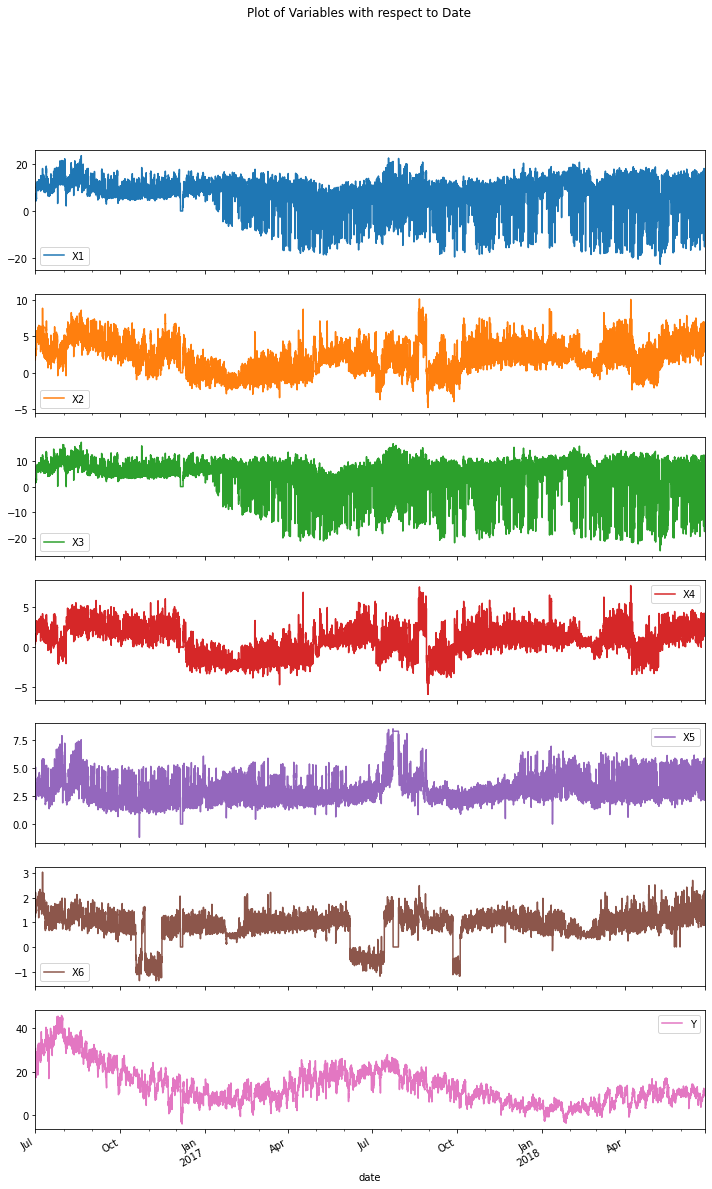

In [5]:
#ref:https://stackoverflow.com/questions/55567706/plot-all-pandas-dataframe-columns-separately
#ref:https://stackoverflow.com/questions/51174691/how-to-increase-image-size-of-pandas-dataframe-plot
fig, axes = plt.subplots(nrows=7, ncols=1,figsize=(12,20));
ax = df.plot(subplots=True, ax=axes, title='Plot of Variables with respect to Date');
plt.gcf().autofmt_xdate();

In the plot we can see that the data appears random here and there is no strong sign of seasonality.

Let's draw a heatmap of correlation between the variables of the data

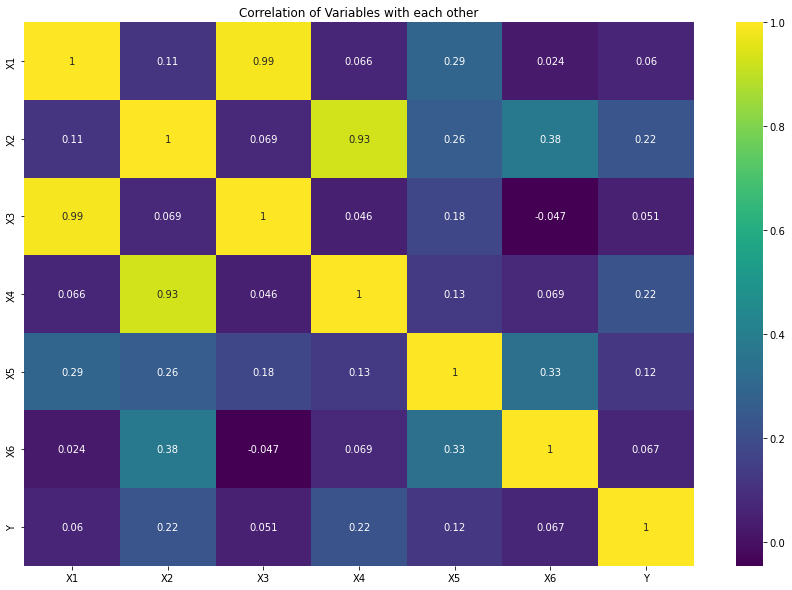

In [6]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True,cmap='viridis');
plt.title('Correlation of Variables with each other');

With our target variable Y both X2 and X4 has the highest correlation which however is not as high we could say it strongly correlated. The variables X1, X3 and X2,X4 has very high correlation with each other.

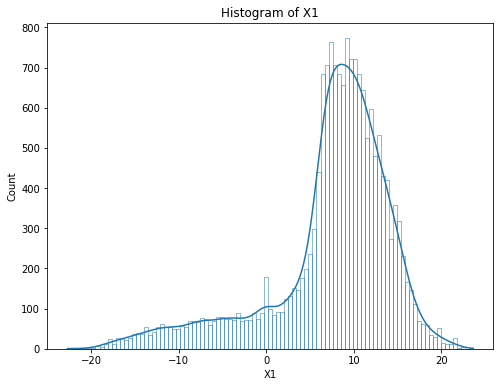

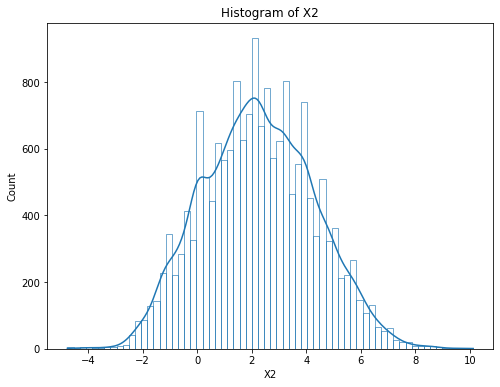

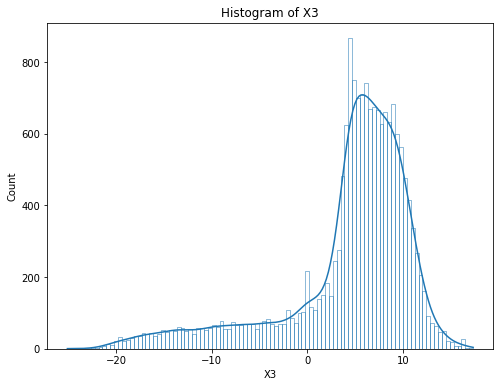

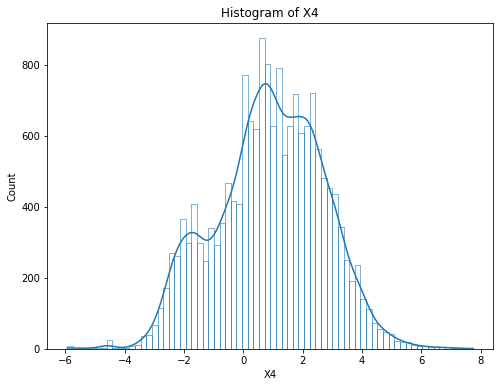

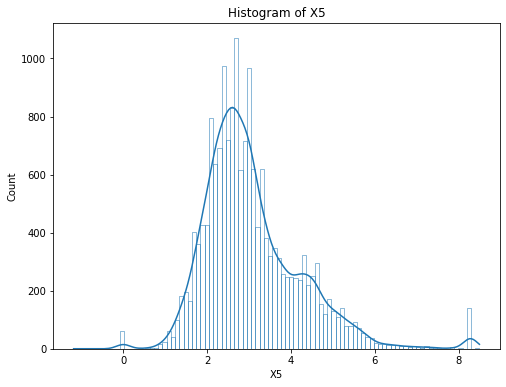

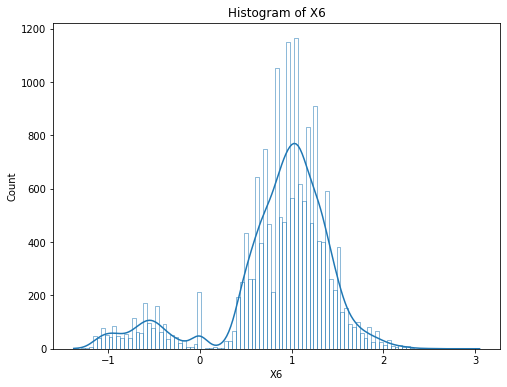

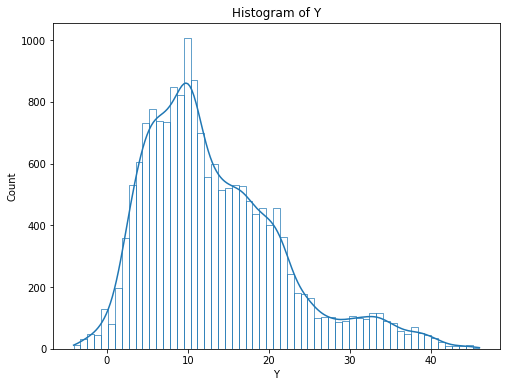

In [7]:
#ref:https://www.kaggle.com/code/patrickgomes/how-to-plot-multiple-graphs-using-for-loop-easy/notebook
for c in df.columns:
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    sns.histplot(df[c],kde=True,fill=False)
    plt.title('Histogram of '+c)

Based on the histogram we can see that the both X1 and X3 are left skewed, while X2, X4, X5 and X6 has sort of normal shape. The variable Y is right skewed.

Let's also make box plot of the variables

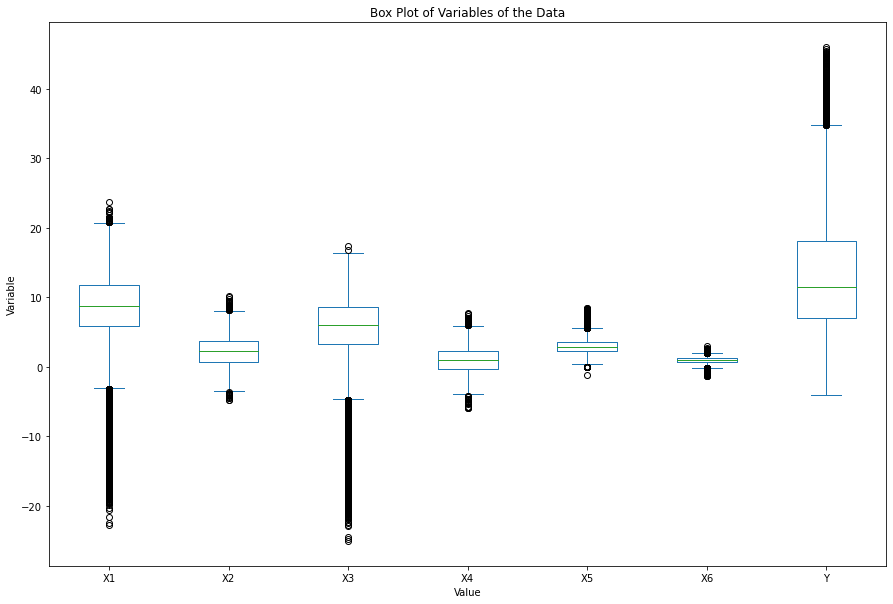

In [8]:
df.plot(kind='box',figsize=(15,10));
plt.title('Box Plot of Variables of the Data');
plt.xlabel('Value');
plt.ylabel('Variable');

Our interpretation of skewness is backed by these box plots.

Let's split our data into train test and val sets

In [9]:
train = df.loc[:'2017-06-27']
val = df.loc['2017-06-27':'2017-10-25']
test = df.loc['2017-10-25':'2018-02-22']

Let's draw a plot marking train, val and test period

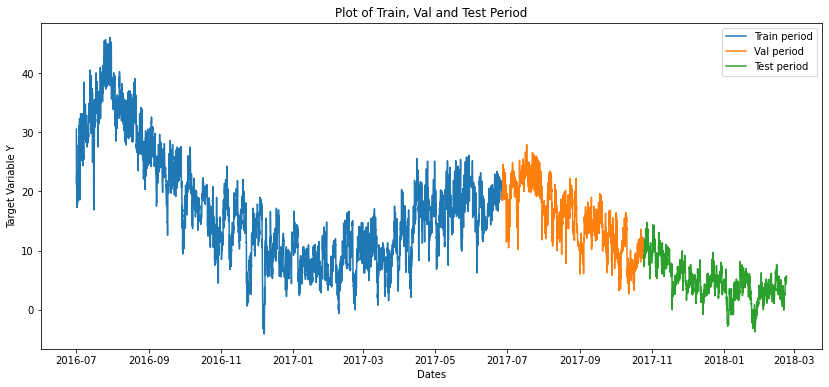

In [10]:
plt.figure(figsize=(14,6))
plt.plot(train.index,train['Y'].values,label='Train period');
plt.plot(val.index,val['Y'].values,label='Val period');
plt.plot(test.index,test['Y'].values,label='Test period');
plt.title('Plot of Train, Val and Test Period');
plt.xlabel('Dates');
plt.ylabel('Target Variable Y');
plt.legend();

In [11]:
#scaling only independent variables
def scale_data(df):
    df = df.copy() #make copy to avoid overwriting
    for c in df.columns[:-1]: #iterate over all columns
        df[c] = (df[c] - df[c].mean())/df[c].std() #normalizing the values
    return df

In [12]:
train = scale_data(train)
val = scale_data(val)
test = scale_data(test)

In [13]:
#let's make matrix X
X = np.append(np.ones(len(train)).reshape(-1,1),train.iloc[:,:-1].values,1)
## To calculate A
A = np.matmul(X.T,X)
b = np.matmul(X.T,train['Y'].values)
## let's make augmented matrix
M = np.append(A,b.reshape(-1,1),1)

In [14]:
def gauss_jordan_elimination(m):
    ## for non-square matrix we are going to take the diag with minimum dimension
    diag = min(m.shape)

    ## forward elimination
    for d in range(diag): #iterate over all diag element
        p_element = m[d,d] #take pivot element
        m[d,:] = m[d,:]/p_element ## divide whole row by pivot
        p_element = m[d,d] #incase pivot gets modified store new
        for s in range(1,diag): #for iterating over other rows
            if d+s>=diag: #to remain in bound
                break
        ## let's find a factor by which we will multiply the pivot row and add into other rows
            factor = -m[d+s,d]/p_element
        ## broadcast the results
            m[d+s,:] = factor*m[d,:] + m[d+s,:]

    ## backward elimination
    for d in range(diag-1,-1,-1): #iterate over all diag element backward
        for s in range(1,diag):  #for iterating over other rows
            if d-s<0: #to remain in bound
                break
            if m[d-s,d] == 0: #to avoid errors
                continue
            factor = -m[d-s,d] #factor by which we will multiply the pivot row and add into other rows
            m[d-s,:] = factor*m[d,:] + m[d-s,:] #broadcast the results
    return m

We know the last column of reduced-row echelon form is our answer

In [15]:
betas = gauss_jordan_elimination(M)[:,-1]

QR Decomposition:

Let's use these learned parameters to calculate the mean absolute error on train, validation and test set

In [16]:
#prediction function
def predict(X):
    x = np.append(np.ones(len(X)).reshape(-1,1),X.iloc[:,:-1].values,1)
    return np.matmul(x,betas.reshape(-1,1))

#MAE calculator
def mean_absolute_error(data):
    pred = predict(data)
    true = data.iloc[:,-1].values.reshape(-1,1)
    return np.mean(np.abs(true-pred))

In [17]:
print('The Mean Absolute error for the train is', mean_absolute_error(train))
print('The Mean Absolute error for the val is', mean_absolute_error(val))
print('The Mean Absolute error for the test is', mean_absolute_error(test))

The Mean Absolute error for the train is 5.449667849615744
The Mean Absolute error for the val is 5.209183686762173
The Mean Absolute error for the test is 12.41788150219231


Plotting True and Predicted targets for train, val and test

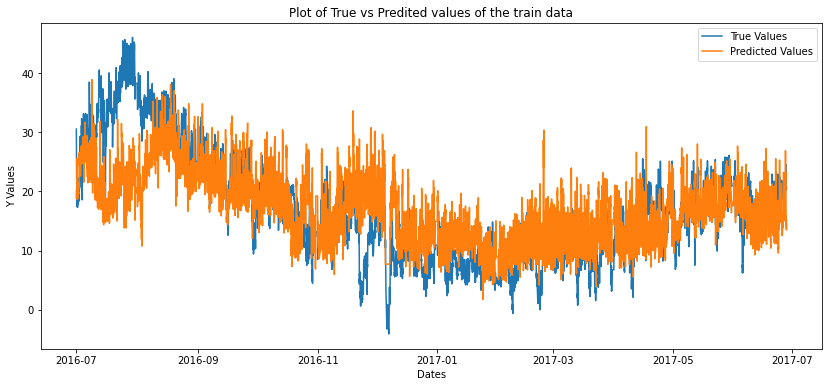

In [18]:
plt.figure(figsize=(14,6))
p = predict(train)
t = train.iloc[:,-1]
plt.plot(train.index,t,label='True Values',)
plt.plot(train.index,p,label='Predicted Values')
plt.title('Plot of True vs Predited values of the train data');
plt.ylabel('Y Values');
plt.xlabel('Dates');
plt.legend()

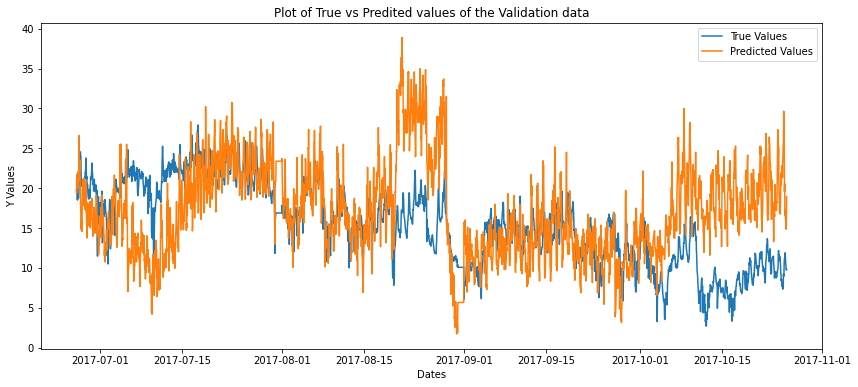

In [19]:
plt.figure(figsize=(14,6))
p = predict(val)
t = val.iloc[:,-1]
plt.plot(val.index,t,label='True Values',)
plt.plot(val.index,p,label='Predicted Values')
plt.title('Plot of True vs Predited values of the Validation data');
plt.ylabel('Y Values');
plt.xlabel('Dates');
plt.legend()

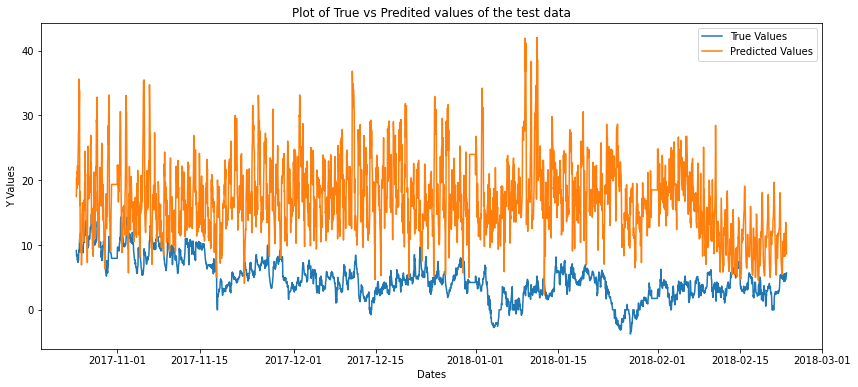

In [20]:
plt.figure(figsize=(14,6))
p = predict(test)
t = test.iloc[:,-1]
plt.plot(test.index,t,label='True Values',)
plt.plot(test.index,p,label='Predicted Values')
plt.title('Plot of True vs Predited values of the test data');
plt.ylabel('Y Values');
plt.xlabel('Dates');
plt.legend()

## 2 - Gradient Descent and Step Length Controller

We are given with Booth Function which is given by equation,
\
$f(x, y)=(x+2 y)^2+(2 x+y-5)^2$
\
\
To find values of x and y which minimizes this function can be computed by taking the partial derivative of the function with respect to x and y
\
\
The partial derivative with respect to x is given as,
\
$f(x)^{\prime}=2(x+2 y) +2(2 x+y-5) \cdot 2 $
\
\
The partial derivative with respect to y is given as,
\
$f(y)^{\prime}=2(x+2 y) \cdot 2 +2(2 x+y-5) $

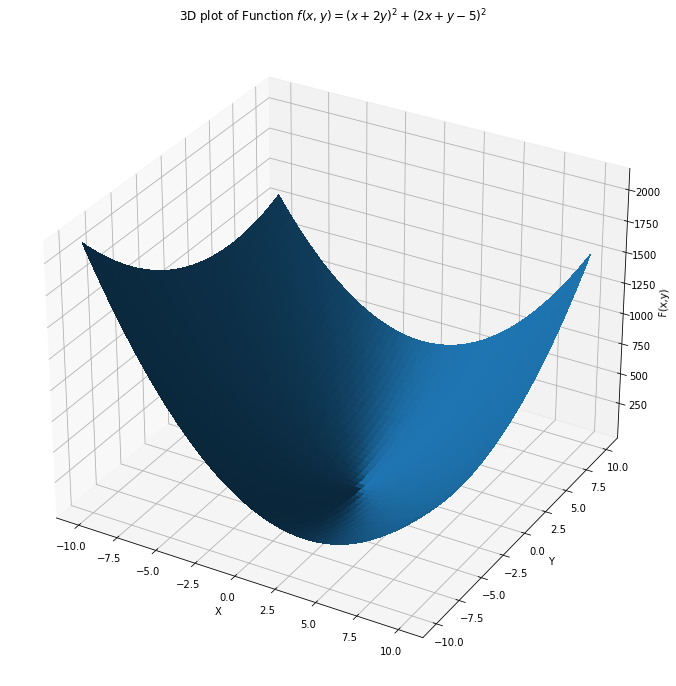

In [5]:
from mpl_toolkits import mplot3d
## first plot the function
x = np.linspace(-10,10,50)
y = np.linspace(-10,10,50)
X,Y = np.meshgrid(x,y)
Z = (X+2*Y)**2 + (2*X+y-5)**2
plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z,linewidth=0, antialiased=False, label = 'F(x,y)' )
ax.set_title('3D plot of Function $f(x, y)=(x+2 y)^2+(2 x+y-5)^2$');
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('F(x,y)');

Now it is time for gradient descent step. Let's make a class that will pick a value of x and y on random and perform gradient descent bunch of times with bunch of learning rate and return the parameters which will minimize the function the most.

In [19]:
#function f(x,y)
def func(x,y):
    return (x+2*y)**2+(2*x+y-5)**2

#partial derivative wrt x 
def derv_fx(x,y):
    return 2*(x+2*y) +2*(2*x+y-5)*2

#partial derivative wrt y
def derv_fy(x,y):
    return 2*(x+2*y)*2+2*(2*x+y-5)

In [20]:
def gradient_descent(x, y, lr):
    iterations = 0 ## for calculating number of iterations
    step_x = 1 ## arbitrary step length to start the loop for x
    step_y = 1 ## arbitrary step length to start the loop for y
    max_iter = 100 ## maximum iterations

    while (np.abs(step_x) > 1e-6) or (np.abs(step_y) > 1e-6): #iterate untill the value of function stops changing below 1e-6 

        #to stop our optimization if the function stops converging after certain number of iterations
        if iterations > max_iter:
            break

        ## for calculating steps wrt both x and y
        step_x = -lr*derv_fx(x,y)
        step_y = -lr*derv_fy(x,y)

        ## for minimizing x,y
        x = x + step_x
        y = y + step_y

        ## increment the iteration
        iterations += 1

    return x,y,iterations

Let's do this bunch of times until we finally reach the minimum

In [21]:
minimum = np.inf
for n in range(10): #number of trials and error steps
    x = np.random.randn(1) #random x
    y = np.random.randn(1) #random y
    lrs = [0.01,0.1,0.2,0.5] #bunch of practical random learning rates
    lr = lrs[np.random.randint(0,4,1)[0]] #pick a random lr from our given list of lr

    x, y, iterations = gradient_descent(x,y,lr) #gradient descent step
    new_f = func(x,y) #new value of f with optimized x, y
    if new_f < minimum: #store the value of x,y which minimize the function most
        minimum = new_f
        optimized_x, optimized_y = x , y
        it = iterations

In [22]:
print('The optimized value of x, y are',np.round(optimized_x[0],3),np.round(optimized_y[0],3),it)

The optimized value of x, y are 3.333 -1.667 67


To control the step length, we need to implement backtracking line search here

In [51]:
#backtracking line search
def backtracking_line_search(x, y, lr=1, alpha=0.1, beta=0.5,):
    while (func(x - lr*derv_fx(x,y), y-lr*derv_fy(x,y)) > func(x,y) + alpha*lr*(derv_fx(x,y)**2 + derv_fy(x,y)**2)):
        lr = beta * lr
    return lr

## Gradient descent with backtracking
def gradient_descent_with_controller(x, y):
    iterations = 0 ## for calculating number of iterations
    step_x = 1 ## arbitrary step length to start the loop for x
    step_y = 1 ## arbitrary step length to start the loop for y
    max_iter = 100 ## maximum iterations
    lr = 1 #1.0 works as a good learning rate for controller

    while (np.abs(step_x) > 1e-6) or (np.abs(step_y) > 1e-6): #iterate untill the value of function stops changing below 1e-6 

        #to stop our optimization if the function stops converging after certain number of iterations
        if iterations > max_iter:
            break
            
        lr = backtracking_line_search(x,y,lr)

        ## for calculating steps wrt both x and y
        step_x = -lr*derv_fx(x,y)
        step_y = -lr*derv_fy(x,y)

        ## for minimizing x,y
        x = x + step_x
        y = y + step_y

        ## increment the iteration
        iterations += 1

    return x,y,iterations

In [60]:
minimum = np.inf
for n in range(1): #number of trials and error steps
    x = 1
    y = 1

    x, y, iterations = gradient_descent_with_controller(x,y) #gradient descent step
    new_f = func(x,y) #new value of f with optimized x, y
    if new_f < minimum: #store the value of x,y which minimize the function most
        minimum = new_f
        optimized_x, optimized_y = x , y
        it = iterations

In [61]:
print('The optimized value of x, y are',np.round(optimized_x[0],3),np.round(optimized_y[0],3))

TypeError: 'float' object is not subscriptable

In [57]:
it

93